# Example of using the PyRadiomics toolbox in Python

First, import some built-in Python modules needed to get our testing data.
Second, import the toolbox, only the `featureextractor` is needed, this module handles the interaction with other parts of the toolbox.

In [5]:
from __future__ import print_function
import six
import glob, os, sys  # needed navigate the system to get the input data

# features are described at https://pyradiomics.readthedocs.io/en/latest/features.html
import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics

import SimpleITK as sitk
import numpy as np
import pandas as pd
import cv2

# Display the images
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import seaborn as sns
print(f'seaborn version = {sns.__version__}')

seaborn version = 0.11.1


In [6]:
ARG_SOURCE_PATH='/hdd/data/radioterapia/ciolaplata'
ARG_DICOM_AND_GAMMA_CSV = "codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv" # 7244 casos
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.all-texture-features-dumb.csv' # pyradiomics with dumb mask and GLCM features from scikit-image.
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.pyradiomics-texture-features-contours.csv' # pyradiomics only with contoured mask.
ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.all-texture-features-contours.csv' # pyradiomics with contoured mask and GLCM features from scikit-image.
# ARG_TEXTURE_FEATURES_CSV='2019-2018-2017.all-texture-features-contours-bounding-rectangle.csv' # pyradiomics with contoured mask and GLCM features from scikit-image with bounding rectangle.
ARG_SEED=23456 # t-SNE
# example image to extract features from
# image_filename = '1.3.6.1.4.1.9590.100.1.2.104687111612620525338811872261145275128.jpeg' # 1 contour
image_filename = '1.3.6.1.4.1.9590.100.1.2.413026936412366497424912997123899479271.jpeg' # 1 contour
# image_filename = '1.3.6.1.4.1.9590.100.1.2.149022879910701913634657645393318300150.jpeg' # 3 contours with thres = 25, 2 with thres = 20
# image_filename = '1.3.6.1.4.1.9590.100.1.2.68178121113821334525403915874018401462.jpeg' # 4 contours with thres = 25, 1 with thres = 20
# image_filename = '1.3.6.1.4.1.9590.100.1.2.76296562210273102234514513081279675861.jpeg' # 3 contours with thres = 25, 1 also with thres = 20
imagePath = os.path.join(ARG_SOURCE_PATH, '2017-opencv-jpeg', image_filename) # the above images are from 2017.

ARG_CONTOUR_MASK=True

ARG_EXTRACT_FEATURES=True
ARG_EXTRACT_GLCM_SEPARATED_FEATURES=True & ARG_EXTRACT_FEATURES # if ARG_EXTRACT_FEATURES is False then no features are extracted.

### Setting up data

In [7]:
os.getcwd()

'/home/pablo/dev/radioterapia/fluence_maps/radiomics'

### Create dumb mask including _almost_ all pixels
If all pixels are included (0, 0, 255, 255) the mask is not created, so I created a (1, 1, 254, 254) mask.

In [8]:
def createDumbMask(image) -> sitk.SimpleITK.Image:
    image_size = image.GetSize()[::-1]
    point = (int(image_size[0]/2), int(image_size[1]/2))  # fill in the index of your point here
    # (254, 254) excluyo 1 pixel de cada lado
    roi_size = (image_size[0]-2, image_size[1]-2)  # x, y, z; uneven to ensure the point is really the center of your ROI

    ma_arr = np.zeros(image_size, dtype='uint8')

    # Compute lower and upper bound of the ROI
    L_x = point[0] - int((roi_size[0]) / 2)
    L_y = point[1] - int((roi_size[1]) / 2)

    U_x = point[0] + int((roi_size[0] - 1) / 2)
    U_y = point[1] + int((roi_size[1] - 1) / 2)

    # ensure the ROI stays within the image bounds
    L_x = max(0, L_x)
    L_y = max(0, L_y)

    U_x = min(image_size[1] - 1, U_x)
    U_y = min(image_size[0] - 1, U_y)

    print(L_x, L_y, U_x, U_y)

    # 'segment' the mask
    ma_arr[L_y:U_y + 1, L_x:U_x+1] = 1  # Add + 1 to each slice, as slicing is done from lower bound to, but not including, upper bound. Because we do want to include our upper bound, add + 1
    print(ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)
    ma.CopyInformation(image)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    #sitk.WriteImage(ma, maskPath, True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks
    return ma

### Create mask from countours

In [9]:
def createMaskFromContours(imagePath, debug=False) -> sitk.SimpleITK.Image:
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 20, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        plt.imshow(image, cmap = 'gray')

    ma_arr = image
    ma_arr = np.where(ma_arr == 255, 1, ma_arr)

    ma = sitk.GetImageFromArray(ma_arr)

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    # sitk.WriteImage(ma, maskPath, True)
    return ma

### Create bounding rectangle mask

In [10]:
# A bounding rectangle mask is of little use when extracting features with pyradiomics, because pyradiomics supports
# any mask so we use countour masks.
def createBoundingRectangleMask(imagePath, debug=False) -> sitk.SimpleITK.Image:
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 25, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    x,y,w,h = cv2.boundingRect(contours[0])

    # image2.shape = (256, 256)
    ma_arr = np.zeros(image2.shape, dtype='uint8')
    ma_arr[y:y+h, x:x+w] = 1
    ma = sitk.GetImageFromArray(ma_arr)
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

        plt.figure(figsize=(12, 12))

        plt.subplot(1,2,1)
        plt.imshow(image2, cmap = 'gray')
        plt.title("Contour mask")

        plt.subplot(1,2,2)
        cv2.rectangle(imgray, (x,y), (x+w,y+h), (128,0,0), 2)
        plt.imshow(imgray, cmap = 'gray')
        plt.title(f"Fluence map with bounding rectangle")

    # we don't need to write the image, we can pass a SimpleITK Image to the extractor
    # sitk.WriteImage(ma, maskPath, True)
    return ma

### Crop image to bounding rectangle

In [11]:
# Use when extracting GLCM features using scikit-image only, not with pyradiomics
def cropToBoundingRectangle(imagePath, debug=False):
    image = cv2.imread(imagePath) 

    # Finding Contours 
    # Use a copy of the image e.g. imgray.copy() since findContours alters the image 
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Second output is our thresholded image.
    # 20 is threshold, 255 is max value
    ret, thresh = cv2.threshold(imgray, 25, 255, 0)

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    x,y,w,h = cv2.boundingRect(contours[0])

    # crop the image and make a copy of it before drawing the rectangle with cv2.rectangle()
    cropped_image = imgray[y:y+h, x:x+w].copy()
    
    # for debugging only
    if debug:
        print(imagePath)
        print("Number of Contours found = " + str(len(contours)))
        print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

        plt.figure(figsize=(12, 12))

        plt.subplot(1,3,1)
        plt.imshow(image2, cmap = 'gray')
        plt.title(f"Contour mask {image2.shape}")

        plt.subplot(1,3,2)
        cv2.rectangle(imgray, (x,y), (x+w,y+h), (128,0,0), 2)
        plt.imshow(imgray, cmap = 'gray')
        plt.title(f"Fluence map\nwith bounding rectangle {imgray.shape}")

        plt.subplot(1,3,3)
        plt.imshow(cropped_image, cmap = 'gray')
        plt.title(f"Fluence map cropped\nto bounding rectangle {cropped_image.shape}")

    return cropped_image

In [12]:
# cropped_image = cropToBoundingRectangle(imagePath, True)

### Cell to play/experiment: find contours, find bounding rectangle, crop image, etc...
For experimentation: cv2.threshold() parameters differ from those in createMaskFromContours()

Number of Contours found = 1
Bounding rectangle (x=87, y=15, w=118, h=197)
(197, 118)


Text(0.5, 1.0, 'Fluence map cropped\nto bounding rectangle (197, 118)')

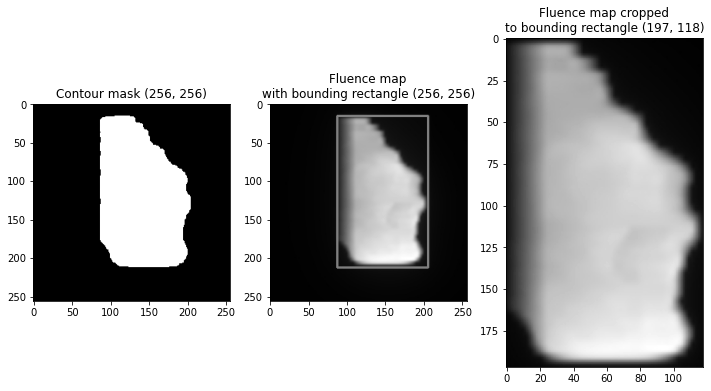

In [13]:
image = cv2.imread(imagePath) # (256, 256, 3)

# Finding Contours 
# Use a copy of the image e.g. imgray.copy() since findContours alters the image 
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # (256, 256, 3)

# Second output is our thresholded image.
# 25 is threshold, 255 is max value
ret, thresh = cv2.threshold(imgray, 25, 255, 0)

# contours is a Python list of all the contours in the image.
# Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
image2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# image2.shape = (256, 256)

x,y,w,h = cv2.boundingRect(contours[0])

print("Number of Contours found = " + str(len(contours)))
print(f"Bounding rectangle (x={x}, y={y}, w={w}, h={h})")

# crop the image and make a copy of it before drawing the rectangle with cv2.rectangle()
cropped_image = imgray[y:y+h, x:x+w].copy()
print(cropped_image.shape)

# draw a rectangle in the image
cv2.rectangle(imgray,(x,y),(x+w,y+h), (128,0,0),2)

plt.figure(figsize=(12, 12))

plt.subplot(1,3,1)
plt.imshow(image2, cmap = 'gray')
plt.title(f"Contour mask {image2.shape}")

plt.subplot(1,3,2)
plt.imshow(imgray, cmap = 'gray')
plt.title(f"Fluence map\nwith bounding rectangle {imgray.shape}")

plt.subplot(1,3,3)
plt.imshow(cropped_image, cmap = 'gray')
plt.title(f"Fluence map cropped\nto bounding rectangle {cropped_image.shape}")

### Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

(256, 256)
/hdd/data/radioterapia/ciolaplata/2017-opencv-jpeg/1.3.6.1.4.1.9590.100.1.2.413026936412366497424912997123899479271.jpeg
Number of Contours found = 1
(256, 256)


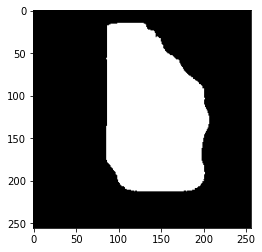

In [14]:
image_1 = sitk.ReadImage(imagePath)
# [::-1] es iterable[inicio:fin:paso]
image_size = image_1.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x
print(image_size)


if ARG_CONTOUR_MASK:
    label_1 = createMaskFromContours(imagePath, debug=True)
else:
    label_1 = createMask(image_1)

image_size = label_1.GetSize()[::-1]
print(image_size)

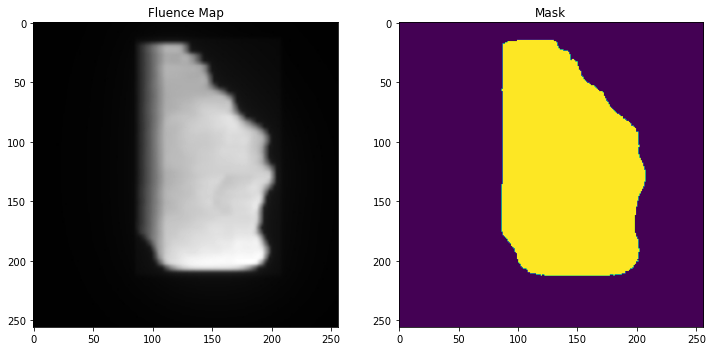

In [15]:
plt.figure(figsize=(12,12))

# 1 row, 2 columns, plot 1
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[:,:], cmap="gray")
plt.title("Fluence Map")
# 1 row, 2 columns, plot 2
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[:,:])        
plt.title("Mask")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object from the parameters set in `Params.yaml`.  Then generate features for the two images.

In [16]:
# Additonally, store the location of the example parameter file, stored in \pyradiomics\examples/exampleSettings
paramPath = os.path.join('.', 'rtParams.yaml')
print('Parameter file, absolute path:', os.path.abspath(paramPath))

Parameter file, absolute path: /home/pablo/dev/radioterapia/fluence_maps/radiomics/rtParams.yaml


### Instantiating the extractor

Now that we have our input, we need to define the parameters and instantiate the extractor.
For this there are three possibilities:

1. Use defaults, don't define custom settings

2. Define parameters in a dictionary, control filters and features after initialisation

3. Use a parameter file

##### Method 3, using a parameter file

In [17]:
# radiomics.setVerbosity(10) # 10: Log messages of level “DEBUG” and up are printed (i.e. all log messages)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': ['10Percentile', '90Percentile', 'Energy', 'Entropy', 'InterquartileRange', 'Kurtosis', 'MeanAbsoluteDeviation', 'Mean', 'Range', 'RobustMeanAbsoluteDeviation', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity', 'Variance'], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'MCC', 'Idmn', 'Id', 'Idn', 'InverseVarianc

### Extract features

Now that we have our extractor set up with the correct parameters, we can start extracting features:

In [18]:
# imageFilepath – SimpleITK Image, or string pointing to image file location
# maskFilepath – SimpleITK Image, or string pointing to labelmap file location
result = extractor.execute(image_1, label_1)

In [19]:
print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
print('')
print('Calculated features')
for key, value in six.iteritems(result):
    print('\t', key, ':', value)

Result type: <class 'collections.OrderedDict'>

Calculated features
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.19.2
	 diagnostics_Versions_SimpleITK : 2.0.2
	 diagnostics_Versions_PyWavelet : 1.1.1
	 diagnostics_Versions_Python : 3.7.5
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1, 2, 4, 8], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 16, 'weightingNorm': None}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : dc5abb3b73910635300e586927e55364069387f0
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 diagnostics_Image-original_Size : (256, 256)
	 diagnostics_Image-o

### Extract GLCM using scikit-image

In [20]:
# The GLCM Tutorial Home Page,
#       http://www.fp.ucalgary.ca/mhallbey/tutorial.htm       
from skimage.feature import greycomatrix, greycoprops
from skimage import io  

image = io.imread(imagePath)

xs = []
ys = []
# Todas las métricas para las distintas distancias están correlacionadas con r > 0.9, entonces sólo uso d = 5
# las métrics 'energy' y 'ASM' tienen una correlación r = 1.0 para todas las distancias y todos los ángulos, entonces sólo uso d = 5 y a = 0
# distances = [1, 2, 4, 8] # d: list of pixel pair distance offsets.
distances = [5]
angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians. Para todas las métricas excepto 'energy' y 'ASM'
a_degress = (np.array(angles)*180/np.pi).astype(np.int)
glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                    symmetric=True, normed=True)
xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
ys.append(greycoprops(glcm, 'correlation')[0, 0])

In [21]:
glcm[:, :, 0, 3].shape

(256, 256)

In [22]:
# results : 2-D ndarray
#    2-dimensional array. `results[d, a]` is the property 'prop' for
#    the d'th distance and the a'th angle.
# ex.: results[2, 1] is results[d=4, a=45]
greycoprops(glcm, 'dissimilarity')

array([[6.4038689 , 6.37613379, 4.35571775, 7.48261527]])

In [23]:
def extract_gclm_separated(image):
    distances = [5] # d: list of pixel pair distance offsets.
    angles = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4] # a: list of pixel pair angles in radians.
    a_degress = (np.array(angles)*180/np.pi).astype(np.int)
    
    # la matriz se calcula para todas las distancias y ángulos,
    # pero las métricas no, sólo para las distancias y ángulos de interés.
    glcm = greycomatrix(image, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    glcm_dict = {}
    features = ['contrast', 'dissimilarity', 'homogeneity', 'correlation']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    
    angles = [0]
    
    features = ['energy', 'ASM']
    for f_name in features:
        m = greycoprops(glcm, f_name)
        for d in range(0, len(distances)):
            for a in range(0, len(angles)):
                name = 'glcmsep_'+f_name+'_'+str(distances[d])+'_'+str(a_degress[a])
                glcm_dict[name] = m[d, a]
                
    return glcm_dict

In [24]:
glcm_dict=extract_gclm_separated(image)
print('Se extrajeron {} GCLM features separadas calculadas en toda la imagen.'.format(len([*glcm_dict]))) # https://www.python.org/dev/peps/pep-0448/
glcm_dict

Se extrajeron 18 GCLM features separadas calculadas en toda la imagen.


{'glcmsep_contrast_5_0': 309.30071899900423,
 'glcmsep_contrast_5_45': 338.2487717309145,
 'glcmsep_contrast_5_90': 290.2675080926296,
 'glcmsep_contrast_5_135': 442.34889140841517,
 'glcmsep_dissimilarity_5_0': 6.403868899402394,
 'glcmsep_dissimilarity_5_45': 6.3761337868480705,
 'glcmsep_dissimilarity_5_90': 4.3557177539840675,
 'glcmsep_dissimilarity_5_135': 7.482615268329558,
 'glcmsep_homogeneity_5_0': 0.552476934964052,
 'glcmsep_homogeneity_5_45': 0.5451228967568381,
 'glcmsep_homogeneity_5_90': 0.6590483924620418,
 'glcmsep_homogeneity_5_135': 0.5251122517009906,
 'glcmsep_correlation_5_0': 0.9763704822470437,
 'glcmsep_correlation_5_45': 0.9743469088914593,
 'glcmsep_correlation_5_90': 0.9778320979191352,
 'glcmsep_correlation_5_135': 0.9664518621753062,
 'glcmsep_energy_5_0': 0.18464616457696026,
 'glcmsep_ASM_5_0': 0.034094206092981895}

In [25]:
glcm_dict=extract_gclm_separated(cropToBoundingRectangle(imagePath))
print('Se extrajeron {} GCLM features separadas calculadas en el bounding rectangle.'.format(len([*glcm_dict]))) # https://www.python.org/dev/peps/pep-0448/
glcm_dict

Se extrajeron 18 GCLM features separadas calculadas en el bounding rectangle.


{'glcmsep_contrast_5_0': 841.5024033062307,
 'glcmsep_contrast_5_45': 885.2540678120173,
 'glcmsep_contrast_5_90': 678.6182468220336,
 'glcmsep_contrast_5_135': 1185.4454595036818,
 'glcmsep_dissimilarity_5_0': 15.92071335519518,
 'glcmsep_dissimilarity_5_45': 15.214980456322156,
 'glcmsep_dissimilarity_5_90': 10.032706567796604,
 'glcmsep_dissimilarity_5_135': 18.329470048177445,
 'glcmsep_homogeneity_5_0': 0.20429007915309416,
 'glcmsep_homogeneity_5_45': 0.20948235817827565,
 'glcmsep_homogeneity_5_90': 0.3158761180034461,
 'glcmsep_homogeneity_5_135': 0.17722432944514194,
 'glcmsep_correlation_5_0': 0.9331597488738627,
 'glcmsep_correlation_5_45': 0.9288200769719773,
 'glcmsep_correlation_5_90': 0.9474850156065207,
 'glcmsep_correlation_5_135': 0.9047036603583672,
 'glcmsep_energy_5_0': 0.03166976816942193,
 'glcmsep_ASM_5_0': 0.0010029742159049304}

In [26]:
def getFeatureNames(result, glcm_dict, glcm_sep=False):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    # le dejo el prefijo 'original_' y se lo saco después
    feature_names = [key for key in result.keys() if key.startswith('original_')]
    if glcm_sep:
        feature_names = feature_names + [*glcm_dict]
    return feature_names

In [27]:
def getRenamedFeatureNames(result, glcm_dict, glcm_sep=False):
    # tomar los keys del diccionario result que empiezan con 'original_'
    # y armar una lista, las que van a ser las columnas del dataframe de features
    # remuevo el prefijo 'original_'
    feature_names = [key[len('original_'):] for key in result.keys() if key.startswith('original_')]
    if glcm_sep:
        feature_names = feature_names + [*glcm_dict]
    return feature_names

In [28]:
renamed_feature_names = getRenamedFeatureNames(result, glcm_dict, ARG_EXTRACT_GLCM_SEPARATED_FEATURES)
renamed_feature_names

['firstorder_10Percentile',
 'firstorder_90Percentile',
 'firstorder_Energy',
 'firstorder_Entropy',
 'firstorder_InterquartileRange',
 'firstorder_Kurtosis',
 'firstorder_MeanAbsoluteDeviation',
 'firstorder_Mean',
 'firstorder_Range',
 'firstorder_RobustMeanAbsoluteDeviation',
 'firstorder_RootMeanSquared',
 'firstorder_Skewness',
 'firstorder_TotalEnergy',
 'firstorder_Uniformity',
 'firstorder_Variance',
 'glcm_Autocorrelation',
 'glcm_JointAverage',
 'glcm_ClusterProminence',
 'glcm_ClusterShade',
 'glcm_ClusterTendency',
 'glcm_Contrast',
 'glcm_Correlation',
 'glcm_DifferenceAverage',
 'glcm_DifferenceEntropy',
 'glcm_DifferenceVariance',
 'glcm_JointEnergy',
 'glcm_JointEntropy',
 'glcm_Imc1',
 'glcm_Imc2',
 'glcm_Idm',
 'glcm_MCC',
 'glcm_Idmn',
 'glcm_Id',
 'glcm_Idn',
 'glcm_InverseVariance',
 'glcm_MaximumProbability',
 'glcm_SumEntropy',
 'glcm_SumSquares',
 'glrlm_GrayLevelNonUniformity',
 'glrlm_GrayLevelNonUniformityNormalized',
 'glrlm_GrayLevelVariance',
 'glrlm_HighG

## Extract features for each .jpeg file in folder and generate .csv with features

In [25]:
def build_jpeg_filename(base, year, filename):
    return os.path.join(base, year + '-opencv-jpeg', filename + '.jpeg')

In [26]:
def extractFeatures(df, glcm_sep=False):
    total = len(df)
    i = 0
    for file in df['jpeg_full_filepath'].values:
        try:
            image = sitk.ReadImage(file)
            shape = image.GetSize()[::-1]
            assert len(shape) == 2, "JPEG files are not grey level (i.e.: do not have 2 channels)"
            assert shape[0] == 256 and shape[1] == 256, "JPEG files are not of size 256x256"

            if ARG_CONTOUR_MASK:
                # generar la máscara para cada imagen
                mask = createMaskFromContours(file)
            
            result = extractor.execute(image, mask)
            for key in result.keys():
                if key.startswith('original_'):
                    df.loc[i, key] = result.get(key)

            if glcm_sep:
                # read image file again using scikit-image
                # image = io.imread(file)
                glcm_dict=extract_gclm_separated(cropToBoundingRectangle(file))
                for key in glcm_dict.keys():
                    df.loc[i, key] = glcm_dict.get(key)
            
            sys.stdout.write('\r>> Features extracted for image %d/%d.' % (i+1, total))
            sys.stdout.flush()
            i += 1

        except OSError as err:
            print('Could not extract features for file {}, error: {}'.format(file, err))

    sys.stdout.write('\n')
    sys.stdout.flush()
    
    return df

In [27]:
if ARG_EXTRACT_FEATURES:
    source_folder = ARG_SOURCE_PATH

    gamma_csv = os.path.join(source_folder, ARG_DICOM_AND_GAMMA_CSV)
    texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
    df_dcm_in = pd.read_csv(gamma_csv, sep=';', delimiter=None, header=0)
    N = len(df_dcm_in)
    feature_names = getFeatureNames(result, glcm_dict, ARG_EXTRACT_GLCM_SEPARATED_FEATURES)
    print("Se extraerán {} features para cada uno de los {} archivos JPEG en {}, y se escribirán en {}."
          .format(len(feature_names), N, gamma_csv, texture_features_csv))

    # agrego una columna constante al dataframe para hacer más simple el armado del full file path de los archivos dicom
    df_dcm_in['base_dir'] = source_folder

    df_features_out = pd.DataFrame(columns=['jpeg_full_filepath', 'gamma_index'] + feature_names)
    df_features_out['jpeg_full_filepath'] = [build_jpeg_filename(row[0], str(row[1]), row[2]) for row in df_dcm_in[['base_dir', 'año', 'fluencia calculada']].values]
    df_features_out['gamma_index'] = df_dcm_in.apply(lambda row: 100.0 - row['uno menos gamma index'], axis=1)


    # df_features_out.loc[:, ['jpeg_full_filepath','gamma_index','firstorder_10Percentile','glszm_LowGrayLevelZoneEmphasis']]
    df_features_out[['jpeg_full_filepath','gamma_index','original_firstorder_10Percentile','original_glszm_LowGrayLevelZoneEmphasis']]

    # extract features
    df_features = extractFeatures(df_features_out, ARG_EXTRACT_GLCM_SEPARATED_FEATURES)

    df_features.columns= ['jpeg_full_filepath', 'gamma_index'] + renamed_feature_names

    df_features.to_csv(texture_features_csv, index=False)
    print(f'Texture features .csv file saved to {texture_features_csv}.\n')

Se extraerán 107 features para cada uno de los 7244 archivos JPEG en /hdd/data/radioterapia/ciolaplata/codex.2019-2018-2017.3mm3%Doseshift10%-localnorm-sinoutliers74.csv, y se escribirán en /hdd/data/radioterapia/ciolaplata/2019-2018-2017.all-texture-features-contours-bounding-rectangle.csv.
>> Features extracted for image 7244/7244.
Texture features .csv file saved to /hdd/data/radioterapia/ciolaplata/2019-2018-2017.all-texture-features-contours-bounding-rectangle.csv.



## Load features from .csv

In [29]:
def gamma_interval(gamma_value):
    if gamma_value < 95.0:
        interval = "< 95%"
    elif gamma_value >= 95.0:
        interval = ">= 95%"
    
    return interval

In [30]:
texture_features_csv = os.path.join(ARG_SOURCE_PATH, ARG_TEXTURE_FEATURES_CSV)
print(f'Se leyeron los texture features de {texture_features_csv}')
df_features_copy = pd.read_csv(texture_features_csv, delimiter=None, header=0)
df_features_copy['gamma interval'] = [gamma_interval(value) for value in df_features_copy['gamma_index']]
df_features_copy

Se leyeron los texture features de /hdd/data/radioterapia/ciolaplata/2019-2018-2017.all-texture-features-contours.csv


,jpeg_full_filepath,gamma_index,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_MeanAbsoluteDeviation,firstorder_Mean,...,glcmsep_homogeneity_5_45,glcmsep_homogeneity_5_90,glcmsep_homogeneity_5_135,glcmsep_correlation_5_0,glcmsep_correlation_5_45,glcmsep_correlation_5_90,glcmsep_correlation_5_135,glcmsep_energy_5_0,glcmsep_ASM_5_0,gamma interval
0,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.161700,39.0,179.0,168420503.0,3.553609,80.0,2.384617,43.242923,110.328763,...,0.675192,0.734153,0.685249,0.963681,0.947032,0.960970,0.956780,0.391329,0.153139,< 95%
1,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.333400,57.0,143.0,137608707.0,3.202009,43.0,4.337078,28.508910,105.301142,...,0.692756,0.754564,0.696850,0.934003,0.938034,0.965054,0.933485,0.366417,0.134262,< 95%
2,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.338600,44.0,189.4,99071259.0,3.423620,50.0,3.261347,38.233898,101.485201,...,0.773535,0.806708,0.753169,0.943875,0.948941,0.956787,0.923593,0.431409,0.186114,< 95%
3,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.513800,38.0,156.0,127584394.0,3.412772,59.0,3.569827,35.361607,93.248742,...,0.689136,0.757079,0.686511,0.941446,0.947786,0.964715,0.932355,0.372224,0.138551,< 95%
4,/hdd/data/radioterapia/ciolaplata/2017-opencv-...,74.604800,42.0,168.0,115808034.0,3.455355,54.0,3.145046,35.219015,103.554644,...,0.712840,0.795125,0.717974,0.924342,0.924818,0.963128,0.933728,0.370250,0.137085,< 95%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7239,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.908812,42.0,219.0,82708569.0,3.828814,106.0,1.853845,54.175644,136.529524,...,0.838608,0.870402,0.852949,0.924654,0.894570,0.946719,0.943147,0.565024,0.319252,>= 95%
7240,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.916852,40.0,193.0,73930017.0,3.734748,99.0,1.912783,49.391322,120.099306,...,0.837322,0.862276,0.834028,0.931610,0.925692,0.947887,0.924572,0.556833,0.310063,>= 95%
7241,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.922824,43.0,211.0,116224955.0,3.772524,89.0,2.123465,49.131626,136.750335,...,0.791731,0.820067,0.796163,0.939045,0.926697,0.954788,0.943066,0.463235,0.214586,>= 95%
7242,/hdd/data/radioterapia/ciolaplata/2018-opencv-...,99.935760,30.0,195.0,12661020.0,3.593701,92.0,2.664589,51.747012,93.331355,...,0.929208,0.937001,0.930572,0.838249,0.781295,0.834829,0.827300,0.874735,0.765162,>= 95%


In [31]:
counts = df_features_copy.groupby(['gamma interval'])['jpeg_full_filepath'].count()
counts['< 95%'], counts['>= 95%']

(1596, 5648)

In [32]:
len(renamed_feature_names)

107

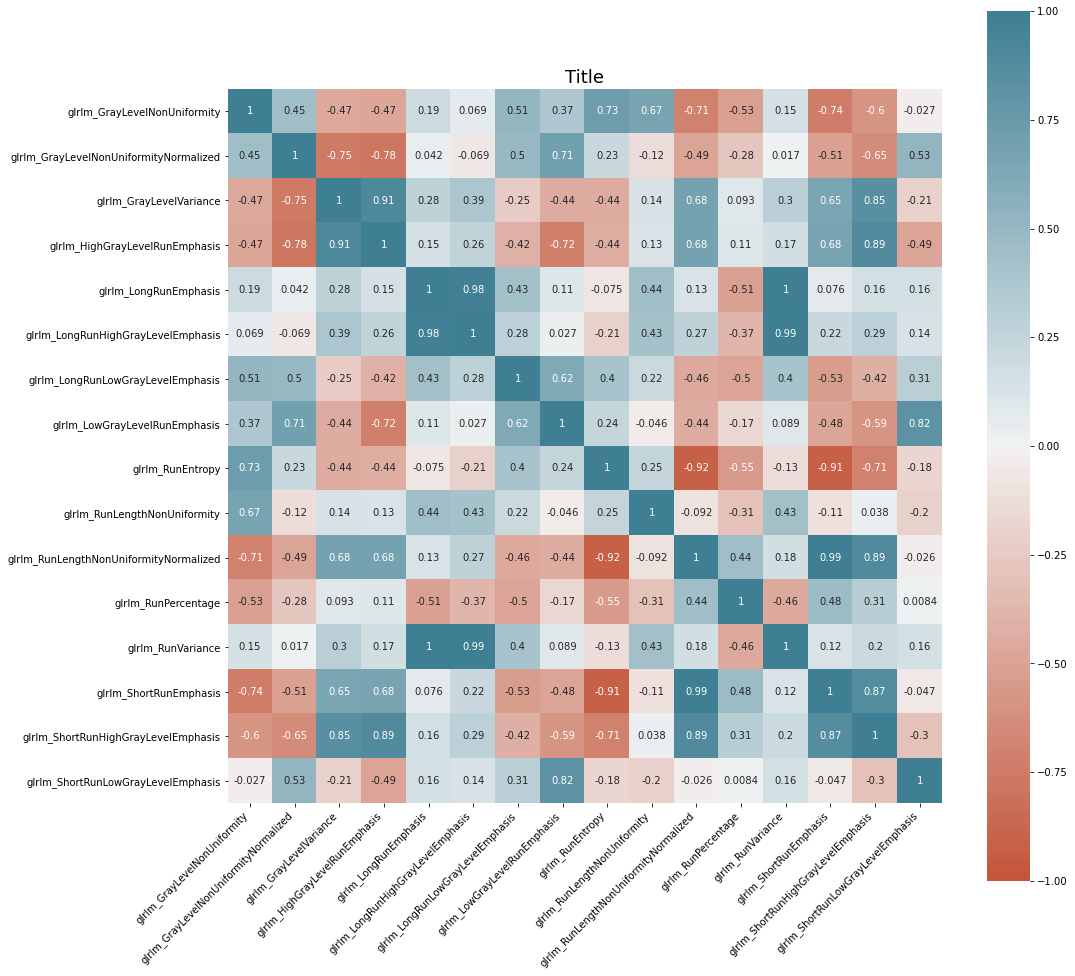

In [33]:
features_of_interest = [name for name in renamed_feature_names if (name.startswith('glrlm_'))]

corr = df_features_copy[features_of_interest].corr()

fig_dims = (16, 16)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0, 0.5, 'Count')

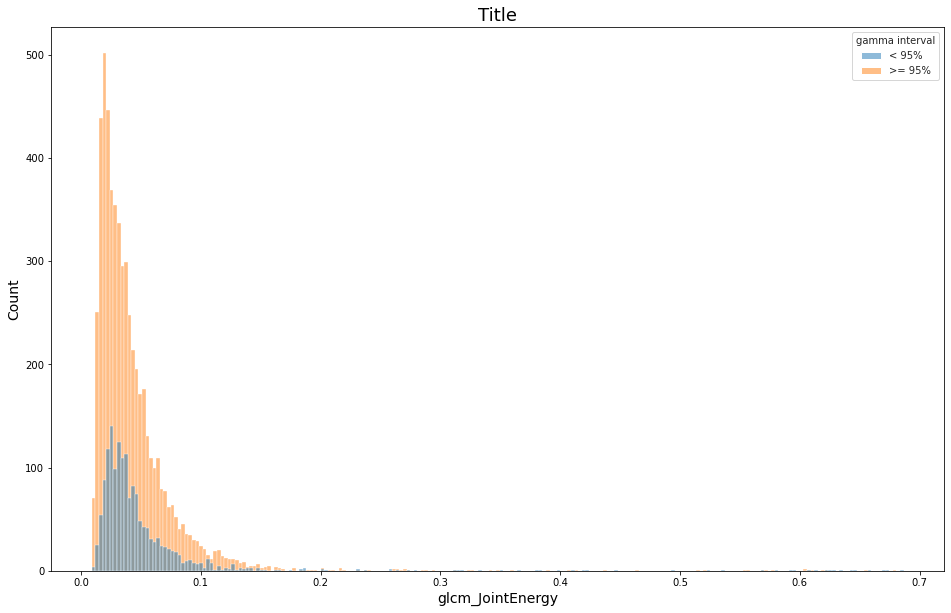

In [34]:
feature = 'glcm_JointEnergy'
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title(f'Title', fontsize=18)

sns.set_style("whitegrid")
ax = sns.histplot(data=df_features_copy, x=feature, hue='gamma interval')
ax.set_xlabel(feature, fontsize=14)
ax.set_ylabel("Count", fontsize=14)

## Compute PCA and t-SNE on texture features

In [49]:
# https://erdem.pl/2020/04/t-sne-clearly-explained
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

features_of_interest = [name for name in renamed_feature_names if (name.startswith('glrlm_')
                                                                   
                                                                   )]
# features_of_interest = features_of_interest + ['firstorder_Energy',
#  'firstorder_Entropy',
#  'firstorder_Variance']

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_features_copy[features_of_interest].values)
df_features_copy['1st component'] = pca_result[:,0]
df_features_copy['2nd component'] = pca_result[:,1] 
df_features_copy['3rd component'] = pca_result[:,2]

np.set_printoptions(precision=2, suppress=True)
print('Varianza explicada por 3 componentes principales (%): {}'.format(pca.explained_variance_ratio_*100))

variance = 0.90 # explicar 80% de la varianza
pca2 = PCA(n_components=variance, svd_solver='full')
pca_result2 = pca2.fit_transform(df_features_copy[features_of_interest].values)
print(f"Cantidad de componentes para explicar un {variance*100}% de la varianza: {pca2.n_components_}")

Varianza explicada por 3 componentes principales (%): [99.95  0.05  0.  ]
Cantidad de componentes para explicar un 90.0% de la varianza: 1


In [50]:
features_of_interest

['glrlm_GrayLevelNonUniformity',
 'glrlm_GrayLevelNonUniformityNormalized',
 'glrlm_GrayLevelVariance',
 'glrlm_HighGrayLevelRunEmphasis',
 'glrlm_LongRunEmphasis',
 'glrlm_LongRunHighGrayLevelEmphasis',
 'glrlm_LongRunLowGrayLevelEmphasis',
 'glrlm_LowGrayLevelRunEmphasis',
 'glrlm_RunEntropy',
 'glrlm_RunLengthNonUniformity',
 'glrlm_RunLengthNonUniformityNormalized',
 'glrlm_RunPercentage',
 'glrlm_RunVariance',
 'glrlm_ShortRunEmphasis',
 'glrlm_ShortRunHighGrayLevelEmphasis',
 'glrlm_ShortRunLowGrayLevelEmphasis']

<AxesSubplot:xlabel='1st component', ylabel='2nd component'>

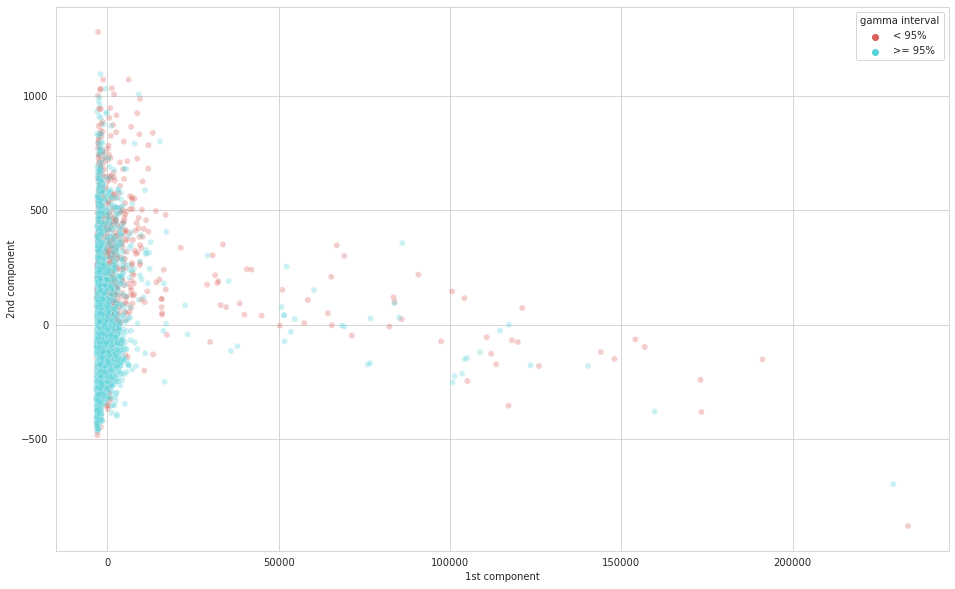

In [51]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="1st component", y="2nd component",
    hue='gamma interval',
    data=df_features_copy,
    legend="full",
    alpha=0.3,
    # palette=sns.color_palette("hls", 2)
    palette=sns.hls_palette(2)
)

In [52]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, random_state=ARG_SEED)
tsne_results = tsne.fit_transform(df_features_copy[features_of_interest].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7244 samples in 0.008s...
[t-SNE] Computed neighbors for 7244 samples in 0.387s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7244
[t-SNE] Computed conditional probabilities for sample 2000 / 7244
[t-SNE] Computed conditional probabilities for sample 3000 / 7244
[t-SNE] Computed conditional probabilities for sample 4000 / 7244
[t-SNE] Computed conditional probabilities for sample 5000 / 7244
[t-SNE] Computed conditional probabilities for sample 6000 / 7244
[t-SNE] Computed conditional probabilities for sample 7000 / 7244
[t-SNE] Computed conditional probabilities for sample 7244 / 7244
[t-SNE] Mean sigma: 16.201713
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.610809
[t-SNE] KL divergence after 500 iterations: 0.685687
t-SNE done! Time elapsed: 24.451733112335205 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

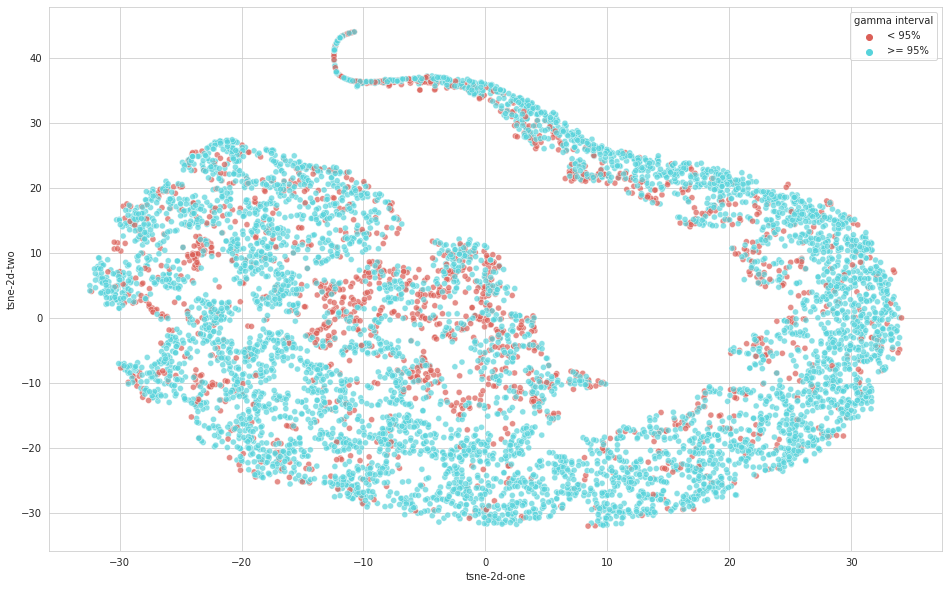

In [53]:
df_features_copy['tsne-2d-one'] = tsne_results[:,0]
df_features_copy['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='gamma interval',
    palette=sns.hls_palette(2),
    data=df_features_copy,
    legend="full",
    alpha=0.7
)

In [35]:
import xgboost as xgb
print('XGBoost version = {}'.format(xgb.__version__))

XGBoost version = 1.3.3


## Train an XGBoost model with extracted CNN features in 2019+2017
Hago cross-validation usando XGBoost directamente. Para cada métrica se informa, en cada iteración, la media y el desvío standard entre los k folds separados con '+', ej.: **test-rmse:71.88373+1.10987**.

CV con el Learning API (core) soporta early stopping.

In [36]:
# excluir mapas de 2018 para comparar con la CNN presentada en ASTRO:
X = df_features_copy
X['year2018'] = [path.find('2018-opencv') != -1 for path in X['jpeg_full_filepath']]
X = X[~X['year2018']]
y = X['gamma_index']

features_of_interest = renamed_feature_names # all features extracted so far help to improve performance in validation set.
# features_of_interest = [name for name in renamed_feature_names if not (name.startswith('glcmsep_'))]
                                                                   
X = X[features_of_interest]
print(X.shape, y.shape)

X_train_cv = X
y_train_cv = y
print(X_train_cv.shape, y_train_cv.shape)

dtrain_cv = xgb.DMatrix(data=X_train_cv, label=y_train_cv)
print(f'DMatrix cols: {dtrain_cv.num_col()} rows: {dtrain_cv.num_row()}')

(4268, 107) (4268,)
(4268, 107) (4268,)
DMatrix cols: 107 rows: 4268


### Resultados con 2019+2018+2017
**Dataset:** '2019-2018-2017.all-texture-features-dumb.csv'

_train-mae:1.11119+0.00764	test-rmse:3.13041+0.08029	test-mae:1.94695+0.03_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 25
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.all-texture-features-dumb.csv' (excluding 2018)

_[489]	train-rmse:1.27878+0.02592	train-mae:0.90220+0.01639	test-rmse:2.98198+0.14417	test-mae:1.92271+0.07347_
```python
param = {'max_depth': 5 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.pyradiomics-texture-features-contours.csv' (excluding 2018)

_[318]	train-rmse:1.45937+0.03612	train-mae:1.01763+0.02408	test-rmse:2.88731+0.09014	test-mae:1.86241+0.04941_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         , 'colsample_bynode': 0.3
         # , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017
**Dataset:** '2019-2018-2017.all-texture-features-contours.csv' (excluding 2018)

_[381]	train-rmse:1.16212+0.01242	train-mae:0.81353+0.00677	test-rmse:2.83408+0.05123	test-mae:1.80370+0.03335_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

### Resultados con 2019+2017 (las GLCM features extraídas con scikit-image aportan más si se calculan sobre todo el mapa y no en el bounding rectangle)
**Dataset:** '2019-2018-2017.all-texture-features-contours-bounding-rectangle.csv' (excluding 2018)
**Nota:** no mejoró sino que empeoró la performance respecto a '2019-2018-2017.all-texture-features-contours.csv' (excluding 2018)'

_[337]	train-rmse:1.27227+0.04079	train-mae:0.88739+0.02571	test-rmse:2.87241+0.07535	test-mae:1.83329+0.04732_
```python
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }
```

In [44]:
param = {'max_depth': 6 # or 'max_depth': 5 + 'colsample_bytree': 0.3
         , 'eta': 0.05
         , 'objective': 'reg:squarederror'
         , 'eval_metric': ['mae']
         # , 'colsample_bytree': 0.3
         # , 'colsample_bynode': 0.3
         , 'colsample_bylevel' : 0.3
         , 'lambda': 2
         , 'alpha': 2
         # , 'tree_method': 'gpu_hist' # usa la GPU
         , 'min_child_weight': 20
        }

print('running cross validation...')
bst = xgb.cv(param, dtrain_cv, nfold=5, num_boost_round=1000, early_stopping_rounds=10, metrics=['rmse', 'mae'],
             seed=ARG_SEED, shuffle=True, verbose_eval=True)

running cross validation...
[0]	train-rmse:90.55853+0.02948	train-mae:90.44142+0.03107	test-rmse:90.55821+0.12496	test-mae:90.44114+0.13143
[1]	train-rmse:86.04310+0.02784	train-mae:85.92459+0.02952	test-rmse:86.04136+0.12433	test-mae:85.92277+0.13097
[2]	train-rmse:81.75354+0.02640	train-mae:81.63333+0.02804	test-rmse:81.75261+0.12212	test-mae:81.63233+0.12900
[3]	train-rmse:77.67849+0.02496	train-mae:77.55639+0.02663	test-rmse:77.67837+0.12324	test-mae:77.55609+0.13036
[4]	train-rmse:73.80734+0.02363	train-mae:73.68303+0.02531	test-rmse:73.80823+0.12168	test-mae:73.68359+0.12914
[5]	train-rmse:70.12988+0.02231	train-mae:70.00314+0.02405	test-rmse:70.13022+0.12114	test-mae:70.00294+0.12877
[6]	train-rmse:66.63652+0.02104	train-mae:66.50704+0.02285	test-rmse:66.63755+0.12136	test-mae:66.50742+0.12912
[7]	train-rmse:63.31792+0.01998	train-mae:63.18553+0.02170	test-rmse:63.31909+0.11815	test-mae:63.18594+0.12619
[8]	train-rmse:60.16549+0.01891	train-mae:60.02992+0.02064	test-rmse:60.1654

[74]	train-rmse:3.24224+0.01154	train-mae:2.78551+0.00756	test-rmse:3.60463+0.06775	test-mae:3.00962+0.05136
[75]	train-rmse:3.16858+0.01097	train-mae:2.70568+0.00786	test-rmse:3.54474+0.06646	test-mae:2.93642+0.04974
[76]	train-rmse:3.10149+0.01205	train-mae:2.63174+0.00829	test-rmse:3.49096+0.06548	test-mae:2.86859+0.04862
[77]	train-rmse:3.03792+0.01064	train-mae:2.56147+0.00773	test-rmse:3.43957+0.06595	test-mae:2.80319+0.04773
[78]	train-rmse:2.97846+0.01177	train-mae:2.49507+0.00848	test-rmse:3.39308+0.06505	test-mae:2.74270+0.04666
[79]	train-rmse:2.92327+0.01168	train-mae:2.43328+0.00826	test-rmse:3.35037+0.06329	test-mae:2.68644+0.04557
[80]	train-rmse:2.87359+0.01150	train-mae:2.37642+0.00835	test-rmse:3.31206+0.06336	test-mae:2.63449+0.04562
[81]	train-rmse:2.82384+0.01084	train-mae:2.32065+0.00826	test-rmse:3.27581+0.06442	test-mae:2.58457+0.04602
[82]	train-rmse:2.77826+0.01006	train-mae:2.26853+0.00807	test-rmse:3.24358+0.06331	test-mae:2.53859+0.04516
[83]	train-rmse:2.7

[149]	train-rmse:1.92684+0.02489	train-mae:1.33321+0.01490	test-rmse:2.86544+0.05992	test-mae:1.85563+0.05035
[150]	train-rmse:1.92093+0.02597	train-mae:1.32913+0.01534	test-rmse:2.86475+0.05972	test-mae:1.85485+0.05016
[151]	train-rmse:1.91443+0.02596	train-mae:1.32456+0.01562	test-rmse:2.86381+0.05984	test-mae:1.85384+0.05016
[152]	train-rmse:1.91048+0.02454	train-mae:1.32148+0.01464	test-rmse:2.86362+0.05977	test-mae:1.85327+0.04987
[153]	train-rmse:1.90513+0.02403	train-mae:1.31759+0.01423	test-rmse:2.86297+0.05939	test-mae:1.85190+0.04897
[154]	train-rmse:1.90022+0.02307	train-mae:1.31397+0.01367	test-rmse:2.86266+0.05986	test-mae:1.85102+0.04935
[155]	train-rmse:1.89189+0.02236	train-mae:1.30809+0.01324	test-rmse:2.86287+0.05913	test-mae:1.85054+0.04904
[156]	train-rmse:1.88587+0.02319	train-mae:1.30400+0.01348	test-rmse:2.86252+0.05942	test-mae:1.84997+0.04899
[157]	train-rmse:1.88103+0.02441	train-mae:1.30028+0.01419	test-rmse:2.86314+0.05858	test-mae:1.84944+0.04860
[158]	trai

[224]	train-rmse:1.61291+0.02398	train-mae:1.12007+0.01317	test-rmse:2.84495+0.05527	test-mae:1.82179+0.04413
[225]	train-rmse:1.60819+0.02525	train-mae:1.11708+0.01402	test-rmse:2.84458+0.05552	test-mae:1.82133+0.04446
[226]	train-rmse:1.60358+0.02470	train-mae:1.11390+0.01361	test-rmse:2.84441+0.05633	test-mae:1.82127+0.04495
[227]	train-rmse:1.60006+0.02334	train-mae:1.11143+0.01263	test-rmse:2.84390+0.05677	test-mae:1.82088+0.04468
[228]	train-rmse:1.59729+0.02396	train-mae:1.10968+0.01297	test-rmse:2.84377+0.05637	test-mae:1.82062+0.04439
[229]	train-rmse:1.59373+0.02433	train-mae:1.10721+0.01326	test-rmse:2.84326+0.05623	test-mae:1.82012+0.04413
[230]	train-rmse:1.58807+0.02414	train-mae:1.10343+0.01292	test-rmse:2.84252+0.05573	test-mae:1.81985+0.04398
[231]	train-rmse:1.58531+0.02393	train-mae:1.10171+0.01274	test-rmse:2.84223+0.05560	test-mae:1.81965+0.04375
[232]	train-rmse:1.58227+0.02312	train-mae:1.09984+0.01238	test-rmse:2.84307+0.05530	test-mae:1.82009+0.04367
[233]	trai

[299]	train-rmse:1.37713+0.02255	train-mae:0.96109+0.01254	test-rmse:2.83745+0.05366	test-mae:1.81078+0.04017
[300]	train-rmse:1.37325+0.02267	train-mae:0.95847+0.01247	test-rmse:2.83700+0.05389	test-mae:1.81050+0.04001
[301]	train-rmse:1.36951+0.02240	train-mae:0.95630+0.01244	test-rmse:2.83702+0.05358	test-mae:1.81019+0.03935
[302]	train-rmse:1.36618+0.02229	train-mae:0.95397+0.01238	test-rmse:2.83684+0.05372	test-mae:1.81006+0.03918
[303]	train-rmse:1.36385+0.02225	train-mae:0.95240+0.01220	test-rmse:2.83663+0.05396	test-mae:1.81000+0.03925
[304]	train-rmse:1.36070+0.02198	train-mae:0.95016+0.01190	test-rmse:2.83630+0.05433	test-mae:1.80969+0.03912
[305]	train-rmse:1.35901+0.02191	train-mae:0.94898+0.01178	test-rmse:2.83626+0.05445	test-mae:1.80967+0.03950
[306]	train-rmse:1.35494+0.02146	train-mae:0.94617+0.01144	test-rmse:2.83644+0.05377	test-mae:1.80973+0.03907
[307]	train-rmse:1.35166+0.02211	train-mae:0.94361+0.01194	test-rmse:2.83632+0.05355	test-mae:1.80937+0.03887
[308]	trai

[374]	train-rmse:1.17787+0.01153	train-mae:0.82448+0.00668	test-rmse:2.83385+0.05125	test-mae:1.80373+0.03381
[375]	train-rmse:1.17569+0.01198	train-mae:0.82292+0.00688	test-rmse:2.83372+0.05144	test-mae:1.80366+0.03387
[376]	train-rmse:1.17355+0.01177	train-mae:0.82147+0.00645	test-rmse:2.83367+0.05132	test-mae:1.80361+0.03365
[377]	train-rmse:1.17051+0.01207	train-mae:0.81943+0.00667	test-rmse:2.83406+0.05125	test-mae:1.80382+0.03364
[378]	train-rmse:1.16858+0.01263	train-mae:0.81813+0.00702	test-rmse:2.83406+0.05110	test-mae:1.80387+0.03356
[379]	train-rmse:1.16715+0.01260	train-mae:0.81707+0.00689	test-rmse:2.83410+0.05122	test-mae:1.80386+0.03372
[380]	train-rmse:1.16426+0.01187	train-mae:0.81502+0.00655	test-rmse:2.83388+0.05113	test-mae:1.80363+0.03347
[381]	train-rmse:1.16212+0.01242	train-mae:0.81353+0.00677	test-rmse:2.83408+0.05123	test-mae:1.80370+0.03335


In [58]:
bst

,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,90.558536,0.029475,90.441414,0.031070,90.558212,0.124959,90.441136,0.131430
1,86.043102,0.027846,85.924590,0.029520,86.041362,0.124332,85.922761,0.130976
2,81.753537,0.026400,81.633330,0.028036,81.752614,0.122121,81.632332,0.128999
3,77.678491,0.024963,77.556387,0.026633,77.678372,0.123240,77.556085,0.130367
4,73.807339,0.023629,73.683026,0.025306,73.808234,0.121684,73.683592,0.129148
...,...,...,...,...,...,...,...,...
367,1.195759,0.013135,0.836801,0.007393,2.833807,0.051941,1.803624,0.034723
368,1.192592,0.012868,0.834666,0.007374,2.833607,0.052642,1.803260,0.034603
369,1.190255,0.013325,0.833014,0.007613,2.833054,0.052253,1.803130,0.034605
370,1.187491,0.012958,0.831226,0.007697,2.833108,0.052215,1.803290,0.034926


TODO: generar nuevo dataset '2019-2018-2017.texture-features-contours.csv' que incluya los features pyradiomics generados con contorno y los features glcm usando scikit-image.